# Title of your assignment

#### Student no : Ozar Ömer Uncu
#### Student name : 21727815


In [213]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar xf spark-3.1.1-bin-hadoop2.7.tgz
!pip install -q findspark


Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graph

In [214]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"


In [215]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
spark = SparkSession.builder.master("local[*]").getOrCreate()
from pyspark.sql.functions import col
import seaborn as sns
import copy
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from pyspark.sql.functions import avg
from pyspark.ml.clustering import KMeans
from sklearn.decomposition import PCA


## Table of Content

[Purpose](#purpose)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling for Clustering](#clusteringmodel)  
[Clustering results](#clustering)    
[Modeling for Classification](#classificationmodel)  
[Evaluation](#evaluation)  
[References](#references)   


## Purpose <a class="anchor" id="purpose"></a>


In this experiment we try to find out how we can detect haricot bean species, using machine learning methods with Spark Environment om the features created by digitizing the images of the various haricot beans.
Our main purpose cluster and classify the data according to types. We have 7 types of haricot beans.

## Data Understanding<a class="anchor" id="data_understanding"></a>

  As you can see below implementation. I print describe of our spark dataframe. We can see summary of our dataframe. Also we can see schema of our dataset. We have 17 columns. Some of our columns can have relations. In this experiment I do not remove any column at first. But next we can observe different methods to visualize data. We have not undefined variable so I want to show drop part of this experiment at below.You can see dropped values count and not dropped values count below too. We do not need to drop any row from our dataframe.

+-------+------------------+------------------+-----------------+-----------------+-------------------+-------------------+------------------+------------------+--------------------+------------------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+--------+
|summary|              Area|         Perimeter|  MajorAxisLength|  MinorAxisLength|       AspectRation|       Eccentricity|        ConvexArea|     EquivDiameter|              Extent|          Solidity|          roundness|        Compactness|        ShapeFactor1|        ShapeFactor2|      ShapeFactor3|        ShapeFactor4|   Class|
+-------+------------------+------------------+-----------------+-----------------+-------------------+-------------------+------------------+------------------+--------------------+------------------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+--------+
|

DataFrame[Class: string, avg(Area): double]

Before drop na values 13611
After drop na values 13611


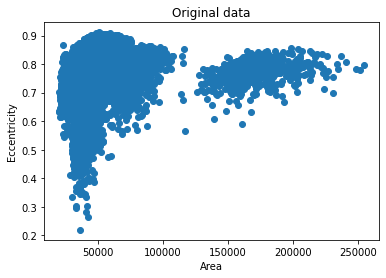

In [216]:
df = spark.read.csv("data.csv",header = True, inferSchema=True)
df.describe().show()
df.printSchema()
df2 = df
display(df.select("Class","Area").groupBy("Class").agg(avg("Area")))
ar_df = df.toPandas()
df = df.drop(col("Class"))
print("Before drop na values",df.count())
df = df.na.drop()
print("After drop na values",df.count())

np_area = np.array(df.select('Area').collect())
np_eccen = np.array(df.select('Eccentricity').collect())
plt.scatter(np_area,np_eccen)
plt.title("Original data")
plt.xlabel("Area")
plt.ylabel("Eccentricity")
plt.show()



  At above I want to show relationship between two attributes Area and Eccentricity. At the below you can see we have these count of species at our dataset.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


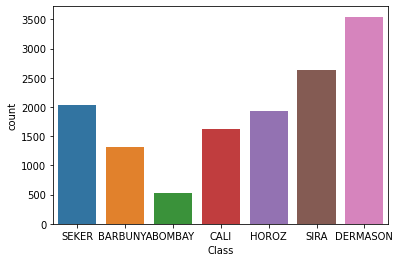

In [217]:
pandas_df = df2.toPandas()
sns.countplot(pandas_df["Class"],label="Count")


## Data Preparation<a class="anchor" id="data_preparation"></a>

  At this part I normalized data for clustering methods. As you can see below I assemble _vec and _scaled column to our spark dataframe. I create pipeline for complete these methods at queue. Also, for the needed situation I take specified columns to another dataframes. Like : *_vec and *_scaled columns. You can see scaled data at below.

Data normalization 

In [218]:
cols = df.columns
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in cols]
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in cols]
pipeline = Pipeline(stages=assemblers + scalers)
scalerModel = pipeline.fit(df)
scaledData = scalerModel.transform(df)
scaledData.show(5)

df_vec = scaledData.select(scaledData.columns[16:32])
df_vec.show(5)
df_sca = scaledData.select(scaledData.columns[32:])
df_sca.show(5)



+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+---------+-------------+-------------------+-------------------+----------------+----------------+--------------+-----------------+-------------+-------------+-------------+---------------+----------------+----------------+----------------+----------------+--------------------+--------------------+----------------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4| A


## Modeling for Clustering <a class="anchor" id="clusteringmodel"></a>


  Choosen clusteering method is KMeans clustering.

> KMeans Clustering
  KMeans is a unsupervised method. Also, it is a very popular clustering method. KMeans is a method of vector quantization. It's purpose is partition n observatition into k clusters in which observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster.

  As you can see from the below I started with Vector Assembler for create feature column to our spark dataframe. It contains our 17 columns at inside as vector. And than I started KMeans clustering with k = 7 and setSeed = 1. Next we need to fit our selected features to kmeans template.Finally fit to our model. We need predictions from this model so we transfrom our selected features transform. I did extra found cluster centers of our values. I want to create a strong visualization so I reduced our 16 dimension (-class column) with PCA.

> PCA
 It is called as Principal Component Analysis. It aimes for for the higher dimension values we decrease our size.It contributes highest variance set and collect this values. We can lost some attributes but these features or attributes contains less information about our species.

Our dimension decreased to 3 variable so I can easily to 3d dimension graph.








+--------------------+
|            features|
+--------------------+
|[28395.0,610.291,...|
|[28734.0,638.018,...|
|[29380.0,624.11,2...|
|[30008.0,645.884,...|
|[30140.0,620.134,...|
|[30279.0,634.927,...|
|[30477.0,670.033,...|
|[30519.0,629.727,...|
|[30685.0,635.681,...|
|[30834.0,631.934,...|
|[30917.0,640.765,...|
|[31091.0,638.558,...|
|[31107.0,640.594,...|
|[31158.0,642.626,...|
|[31158.0,641.105,...|
|[31178.0,636.888,...|
|[31202.0,644.454,...|
|[31203.0,639.782,...|
|[31272.0,638.666,...|
|[31335.0,635.011,...|
+--------------------+
only showing top 20 rows

[6.97140411e+04 1.03397673e+03 3.88529812e+02 2.30627951e+02
 1.69548824e+00 7.97804784e-01 7.08381022e+04 2.97787058e+02
 7.49019754e-01 9.84150253e-01 8.20281648e-01 7.68720861e-01
 5.58607847e-03 1.21013407e-03 5.92787386e-01 9.92661430e-01]
[3.13156295e+04 6.55184418e+02 2.39480805e+02 1.66813062e+02
 1.44465081e+00 7.06352161e-01 3.16841909e+04 1.99322877e+02
 7.56908241e-01 9.88292047e-01 9.14257421e-01 8.3393890

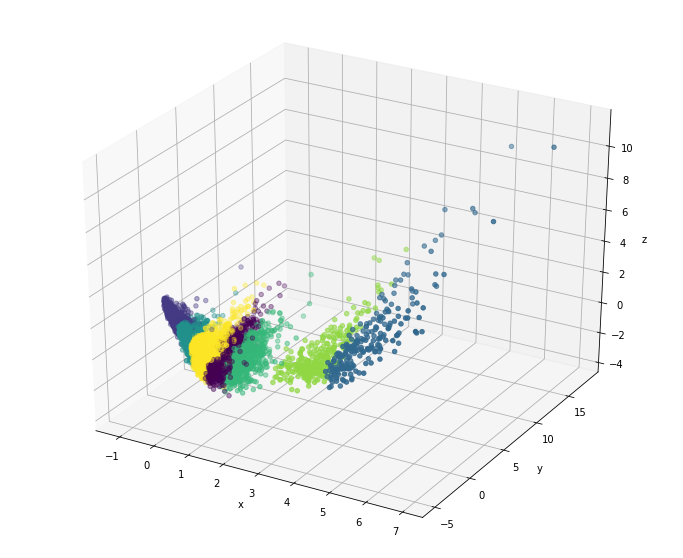

In [219]:
vecAssembler = VectorAssembler(inputCols=df.columns, outputCol="features")
df_kmeans = vecAssembler.transform(df).select('features')
df_kmeans.show()

kmeans = KMeans().setK(7).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans.select('features'))

prediction = model.transform(df_kmeans.select('features'))
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator()
score  = evaluator.evaluate(prediction)
for center in model.clusterCenters():
  print(center)

pca = PCA(n_components = 3, whiten=True)
pand = df.toPandas()
pred = prediction.toPandas()
pca.fit(pand)
model_pca = pca.transform(pand)
pred.head()

dff = pd.DataFrame(model_pca,columns = ['x','y','z'])
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(dff.x, dff.y, dff.z, c= pred.prediction)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()


**Above graph is for original dataset(OD).**

You can detect our species at above graph.

! I could not specified which attributes I used for the dimension. 

+--------------------+
|            features|
+--------------------+
|[0.03405267382875...|
|[0.03550017933696...|
|[0.03825855266528...|
|[0.04094006729406...|
|[0.04150369775743...|
|[0.04209721771507...|
|[0.04294266341013...|
|[0.04312200037575...|
|[0.04383080838272...|
|[0.04446702761789...|
|[0.04482143162137...|
|[0.04556439905036...|
|[0.04563271789441...|
|[0.04585048420980...|
|[0.04585048420980...|
|[0.04593588276486...|
|[0.04603836103093...|
|[0.04604263095868...|
|[0.04633725597362...|
|[0.04660626142205...|
+--------------------+
only showing top 20 rows

[0.04889114 0.09357248 0.10878601 0.12883421 0.31863667 0.73938673
 0.04765799 0.09717184 0.64817427 0.9152395  0.8410067  0.52785754
 0.64721569 0.5269399  0.4755555  0.94723056]
[0.23065584 0.36887447 0.38353319 0.34870495 0.44762851 0.82601683
 0.22658609 0.35780435 0.64295275 0.8579639  0.67027029 0.39208349
 0.33683914 0.20803432 0.343146   0.86253352]
[0.14701937 0.27477399 0.34464979 0.19083852 0.70074318 0.9337

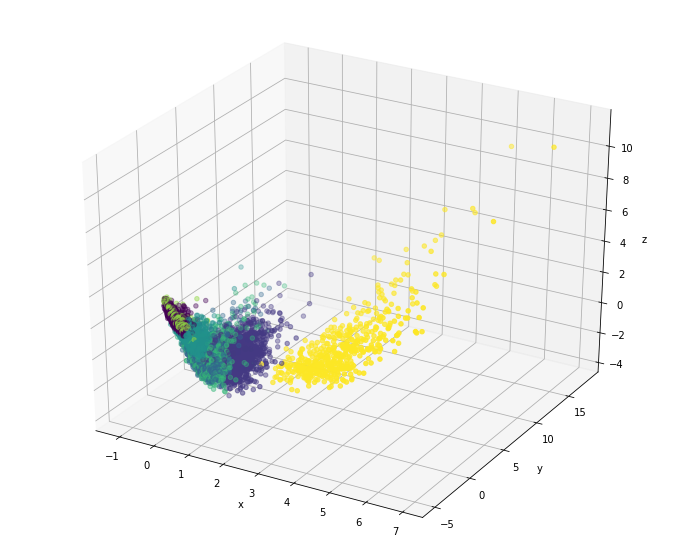

In [220]:
vecAssembler = VectorAssembler(inputCols=df_sca.columns, outputCol="features")
df_kmeans_sca = vecAssembler.transform(df_sca).select('features')
df_kmeans_sca.show()

kmeans = KMeans().setK(7).setSeed(1).setFeaturesCol("features")
model_sca = kmeans.fit(df_kmeans_sca.select('features'))

prediction_sca = model_sca.transform(df_kmeans_sca.select('features'))
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator()


for center in model_sca.clusterCenters():
  print(center)
prediction_sca.show()

pred_sca = prediction_sca.toPandas()
pred_sca.head()

threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(dff.x, dff.y, dff.z, c= pred_sca.prediction)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()


**Above graph is for normalized dataset(ND).**

You can detect our species at above graph.

! I could not specified which attributes I used for the dimension. 

## Modeling for Classification <a class="anchor" id="classificationmodel"></a>

I choosen classification method is LogisticRegression.


> In statistics, the logistic model (or logit model) is used to model the probability of a certain class or event existing such as pass/fail, win/lose, alive/dead or healthy/sick. This can be extended to model several classes of events such as determining whether an image contains a cat, dog, lion, etc. Each object being detected in the image would be assigned a probability between 0 and 1, with a sum of one. - https://en.wikipedia.org/wiki/Logistic_regression

As you can see from definition of logistic regression. It will be suitable for our dataframe. But before we need to some specific preparation for classification part. As you can see below first we need to transport dataframe to new spark dataframe for use our methods next. Than we create indexedlabel column from classes variables actually we need some numberic expressions for our pipeline structure which will come after this part. It contributes these numberic expressions by occurrence of that species. We vectorIndexer next that will be contributes not take exinct element to our new dataframe. Than we basicly split our data with ratios 0.7 and 0.3. You can find dataframes modified model at below.

This part has codes from 
https://github.com/ahmetalkilinc/DataScienceTutorials/blob/master/BBM469_Tutorial_8_Machine_Learning_with_Spark.ipynb




In [221]:
from pyspark.ml.feature import StringIndexer
df2.show()

def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

transformed = transData(df2)
transformed.show(5)

labelIndexer = StringIndexer(inputCol='label', outputCol='indexedLabel').fit(transformed)
labelIndexer.transform(transformed).show(5, True)

featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=4).fit(transformed)
featureIndexer.transform(transformed).show(5, True)


(trainingData, testData) = transformed.randomSplit([0.7, 0.3])

trainingData.show(5,False)
testData.show(5,False)


+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
| Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Class|
+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
|28395|  610.291|    208.1781167|     173.888747| 1.197191424| 0.549812187|     28715|  190.1410973|0.763922518|0.988855999|0.958027126|0.913357755| 0.007331506| 0.003147289| 0.834222388| 0.998723889|SEKER|
|28734|  638.018|    200.5247957|    182.7344194| 1.097356461| 0.411785251|     29172|  191.2727505|0.783968133|0.984985603|0.887033637|0.953860842| 0.006978659| 0.00356362

For this part you can see pipeline for our classification method.At last it contributes us label and predictedLabel. This predictedLabel come from our predictions.And build we pass training data to pipeline first and transform model with test datas as classification sequence. At last we select features , label and predictedlabel columns for show our classification work properly or not.

In [222]:
from pyspark.ml.classification import LogisticRegression
import itertools

logr = LogisticRegression(featuresCol='indexedFeatures', labelCol='indexedLabel')


labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",labels=labelIndexer.labels)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr,labelConverter])

model = pipeline.fit(trainingData)

predictions = model.transform(testData)

predictions.select("features","label","predictedLabel").show()


+--------------------+--------+--------------+
|            features|   label|predictedLabel|
+--------------------+--------+--------------+
|[20786.0,534.717,...|DERMASON|      DERMASON|
|[20942.0,530.683,...|DERMASON|      DERMASON|
|[21348.0,530.825,...|DERMASON|      DERMASON|
|[21570.0,538.454,...|DERMASON|      DERMASON|
|[21636.0,545.616,...|DERMASON|      DERMASON|
|[21666.0,531.318,...|DERMASON|      DERMASON|
|[21830.0,543.295,...|DERMASON|      DERMASON|
|[21877.0,542.194,...|DERMASON|      DERMASON|
|[22144.0,557.585,...|DERMASON|      DERMASON|
|[22190.0,564.639,...|DERMASON|      DERMASON|
|[22205.0,564.439,...|DERMASON|      DERMASON|
|[22333.0,545.278,...|DERMASON|      DERMASON|
|[22449.0,554.779,...|DERMASON|      DERMASON|
|[22721.0,553.6,20...|DERMASON|      DERMASON|
|[22748.0,554.747,...|DERMASON|      DERMASON|
|[22777.0,563.861,...|DERMASON|      DERMASON|
|[22838.0,563.396,...|DERMASON|      DERMASON|
|[23018.0,578.382,...|DERMASON|      DERMASON|
|[23033.0,556

Accuracy is one metric for evaluating classification models. Informally, accuracy is the fraction of predictions our model got right 
Accuracy = number of correct predictions / total number of predictions.
- [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy#:~:text=Estimated%20Time%3A%206%20minutes,predictions%20Total%20number%20of%20predictions) 


In [223]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % (accuracy))
print("Test Error = %g" % (1.0 - accuracy))


Accuracy = 0.91455
Test Error = 0.0854498


For the last part of our classification sequence we need to visualize our results. The best way to show them relationships with each other clearly.

In [224]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[977  73  19   0   0   1   0]
 [ 78 720  19  20   3   2   0]
 [ 13  19 568   0   0   6   0]
 [  4   9   0 563   5   2   0]
 [  0   6   0  11 489  21   0]
 [  0  12   3   3  31 374   0]
 [  0   0   0   0   0   0 162]]


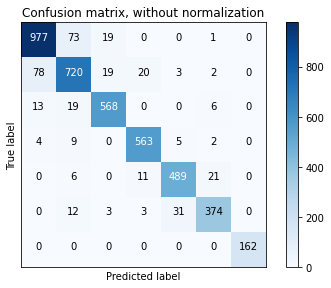

In [225]:
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = map(str, class_temp)

from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=list(class_names))
cnf_matrix

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(class_names),title='Confusion matrix, without normalization')
plt.show()


We do not need to give normalized values to classifications methods. From the confusion matrix it can contributes normalized matrix of our predictions.

Normalized confusion matrix
[[9.13084112e-01 6.82242991e-02 1.77570093e-02 0.00000000e+00
  0.00000000e+00 9.34579439e-04 0.00000000e+00]
 [9.26365796e-02 8.55106888e-01 2.25653207e-02 2.37529691e-02
  3.56294537e-03 2.37529691e-03 0.00000000e+00]
 [2.14521452e-02 3.13531353e-02 9.37293729e-01 0.00000000e+00
  0.00000000e+00 9.90099010e-03 0.00000000e+00]
 [6.86106346e-03 1.54373928e-02 0.00000000e+00 9.65694683e-01
  8.57632933e-03 3.43053173e-03 0.00000000e+00]
 [0.00000000e+00 1.13851992e-02 0.00000000e+00 2.08728653e-02
  9.27893738e-01 3.98481973e-02 0.00000000e+00]
 [0.00000000e+00 2.83687943e-02 7.09219858e-03 7.09219858e-03
  7.32860520e-02 8.84160757e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00]]


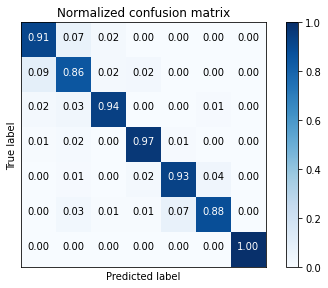

In [226]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(class_names), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## References<a class="anchor" id="references"></a>



1.   https://github.com/ahmetalkilinc/DataScienceTutorials/blob/master/BBM469_Tutorial_8_Machine_Learning_with_Spark.ipynb
2.   https://tr.wikipedia.org/wiki/K-means_k%C3%BCmeleme
3.   https://developers.google.com/machine-learning/crash-course/classification/accuracy#:~:text=Estimated%20Time%3A%206%20minutes,predictions%20Total%20number%20of%20predictions
4.https://medium.com/@gulcanogundur/pca-principal-component-analysis-temel-bile%C5%9Fenler-analizi-bf9098751c62
5.https://plotly.com/python/v3/apache-spark/
6.https://margaretmz.medium.com/running-jupyter-notebook-with-colab-f4a29a9c7156
7.https://stackoverflow.com/questions/42116143/extracting-numpy-array-from-pyspark-dataframe
8.https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html
9.https://datatofish.com/numpy-array-to-pandas-dataframe/
10.https://campus.datacamp.com/courses/machine-learning-with-pyspark/classification-2?ex=1
11.https://learn.datacamp.com/
12.https://www.python.org/
13.https://spark.apache.org/docs/latest/api/python/
14.https://pandas.pydata.org/
15. https://numpy.org/